In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json

from cmdstanpy import CmdStanModel
import arviz as az

from glob import glob

import os

from scipy.ndimage import gaussian_filter

In [2]:
data = pd.read_csv('./dataStore/datas_2_ref.csv',index_col=0)
#data = pd.read_csv('./dataStore/microrheology.csv',index_col=0)

names = {'AlgVLVG0_0Ca_2mgmlcollagen':'Collagen',
        'AlgLVLG15_3Ca_2mgmlcollagen':'IPN soft',
        'AlgVLVG15_22Ca_2mgmlcollagen':'IPN medium',
        'AlgVLVG15_40Ca_2mgmlcollagen':'IPN stiff'}

data['type'] = data['type'].apply(lambda x: names[x])

In [3]:
# create a Boolean mask for the rows to remove
mask = data['type'] == 'IPN stiff'

# select all rows except the ones that contain 'Coca Cola'
data = data[~mask].reset_index(drop=True)
data["size"] = data["size"].astype("int")

In [4]:
def _gen_indices(data,names,idx,indices,orig_indices):
    # generate running indices based on the hierarchy
    
    # break recursion if at the end of hierarchy
    if idx>=len(names):
        return indices,orig_indices
    for ii,i in data.groupby(names[idx]):
        counts = i.shape[0]
        latest = 1
        l = indices[names[idx]]
        if len(l) != 0:
            latest = l[-1]+1
        # add running indices to the current level hierarchy
        indices[names[idx]].extend([latest]*counts)
        orig_indices[names[idx]].extend([ii]*counts)
        indices,orig_indices = _gen_indices(i,names,idx+1,indices,orig_indices)
    return indices,orig_indices

def index(name):
    # index vector outside hierarchy
    indices = np.zeros(data.shape[0],dtype=int)
    orig = np.zeros(data.shape[0],dtype=object)
    for idx,i in enumerate(np.unique(data[name])):
        mask = data[name]==i
        indices[mask] = idx
        orig[mask] = i
    return indices,orig

In [5]:
# hierarcical indexing
gnames = ['type','day','sample','holder','location','track_id']
g_indices = {i:[] for i in gnames}
g_orig_indices = {i:[] for i in gnames}

indices,orig_indices = _gen_indices(data,gnames,0,g_indices,g_orig_indices)

# outside hierarchy
size_indices,size_orig = index('size')
coating_indices,coating_orig = index('coating')

In [6]:
# relative scaling
#normalize = lambda x: data[x].sub(data.groupby('type')[x].transform('mean'))\
#             .div(data.groupby('type')[x].transform('std'))

# global scaling
#normalize = lambda x: data[x].sub(data.groupby('type')[x].transform('mean'))\
#             .div(data[x].std())

# global scaling
#normalize = lambda x: data[x].sub(data[x].mean())\
#             .div(data[x].std())

normalize = lambda x: data[x]\
             .div(data[x].std())

data['G_abs_normed'] = normalize('G_abs')
data['phi_normed'] = normalize('phi_(rad)')
data['radius_(m)'] = normalize('radius_(m)')

In [29]:
data_json = {**{f'N_{i}':len(np.unique(j)) for i,j in indices.items()},
             **{f'{i}_ids':j for i,j in indices.items()},
             'y':data['G_abs_normed'].tolist(),
             'N':data.shape[0]}

#data_json = {**{f'N_{i}':len(np.unique(j)) for i,j in indices.items()},
#             **{f'{i}_ids':j for i,j in indices.items()},
#             'size_ids':(size_indices+1).tolist(),
#             'N_size':len(np.unique(size_indices)),
#             'y':data['G_abs_normed'].tolist(),
#             'N':data.shape[0]}


with open('./dataStore/data.json','w') as f:
    json.dump(data_json,f)

In [30]:
model = CmdStanModel(stan_file='./model/model_o.stan')
fit = model.sample(data='./dataStore/data.json', show_progress=True,adapt_delta=0.99,max_treedepth=15)
print(fit.diagnose())

07:04:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

07:07:49 - cmdstanpy - INFO - CmdStan done processing.
07:07:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[480] is inf, but must be finite! (in 'model_o.stan', line 54, column 2 to column 70)
	Exception: normal_lpdf: Location parameter[480] is inf, but must be finite! (in 'model_o.stan', line 54, column 2 to column 70)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'model_o.stan', line 54, column 2 to column 70)
Exception: normal_lpdf: Location parameter[414] is inf, but must be finite! (in 'model_o.stan', line 54, column 2 to column 70)
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in 'model_o.stan', line 54, column 2 to column 70)
Exception: normal_lpdf: Location parameter[414] is -inf, but must be finite! (in 'model_o.stan', line 54, column 2 to column 70)
Consider re-running with show_console=True if the above output is unclear!



Processing csv files: C:\Users\lehto\AppData\Local\Temp\tmplsmm_dzn\model_odz9urct7\model_o-20241230070430_1.csv, C:\Users\lehto\AppData\Local\Temp\tmplsmm_dzn\model_odz9urct7\model_o-20241230070430_2.csv, C:\Users\lehto\AppData\Local\Temp\tmplsmm_dzn\model_odz9urct7\model_o-20241230070430_3.csv, C:\Users\lehto\AppData\Local\Temp\tmplsmm_dzn\model_odz9urct7\model_o-20241230070430_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [7]:
def comp(name1,name2,df):
    a = df[name1].values
    b = df[name2].values
    r = np.sum((a-b)>0)/a.shape[0]
    label = 'P( {} > {} ) = {:.4f}'.format(name1,name2,r)
    return r

def comp_all(names,df):
    probs = {}
    for i in names:
        probs[i] = {}
        for j in names:
            #if i != j:
            probs[i][j] = comp(i,j,df)
    return probs

az_sample = az.from_cmdstanpy(fit,posterior_predictive='y_hat',
                        log_likelihood='log_likelihood',
                        observed_data={'y':data_json['y']})

name_list = ['Collagen',"IPN-2.5", 'IPN-40' ]

vals = fit.draws_pd().filter(regex='^sigma_holder')
vals.columns =  name_list #,'IPN stiff'

probabilities = comp_all(name_list, vals)

NameError: name 'fit' is not defined

In [46]:
rheology_paths = glob("F:/instru_projects/rheology/rheology/*.csv")

listat = ["Collagen", "Collagen", "IPN-2.5", "IPN-2.5", "IPN-2.5", "IPN-40",  "IPN-40", "IPN-40"]

for i in range(len(rheology_paths)):
    current_path = rheology_paths[i]
    part = os.path.split(current_path)[1]
    parts = part.split("_")
    df_tmp = pd.read_csv(current_path, encoding='utf-16', delimiter="\t", decimal= ",")
    #
    del df_tmp[df_tmp.columns[0]]
    del df_tmp["Strain Hardening Index"]
    #df_tmp = df_tmp.replace(to_replace='None', value=np.nan).dropna()


    df_tmp["matrix"] = parts[0]
    df_tmp["day"] = parts[3]
    df_tmp["Ca"] = parts[5]
    df_tmp["run_num"] = int(parts[-1][:2])
    df_tmp["label"] = listat[i]

    if i == 0:
        df_macro = df_tmp
    else: 
        df_macro = pd.concat((df_macro, df_tmp))

df_macro.fillna(0)

df_osc = df_macro[df_macro["Time"] < 120]
df_freq = df_macro[(df_macro["Time"] < 180) & (df_macro["Time"] > 120)]
df_strain = df_macro[df_macro["Time"] > 180]




,Time,Temperature,Complex Shear Modulus,Storage Modulus,Loss Modulus,Phase Shift Angle,Loss Factor,Angular Frequency,Shear Strain,Complex Viscosity,Torque,Frequency,Shear Strain.1,Shear Stress,matrix,day,Ca,run_num,label,Point No.
99,100.0,37.0,20.4730,20.2710,2.86810,8.05,0.141,0.314,2.45,65.1680,2.309300,0.05,2.45,0.501360,col,230413,0,1,Collagen,NaN
99,100.0,37.0,24.0480,23.7990,3.45570,8.26,0.145,0.314,2.45,76.5480,2.712100,0.05,2.45,0.588810,col,230414,0,2,Collagen,NaN
99,100.0,37.0,1.1745,1.1513,0.23204,11.39,0.202,0.314,1.01,3.7385,0.054321,0.05,1.01,0.011804,IPN15,240221,3mM,3,IPN-2.5,NaN
99,100.0,37.0,11.5030,11.4380,1.22070,6.09,0.107,0.314,1.01,36.6170,0.532050,0.05,1.01,0.115610,IPN15,240222,3mM,1,IPN-2.5,NaN
99,100.0,37.0,1330.6000,1304.0000,264.61000,11.47,0.203,0.314,1.01,4235.5000,61.597000,0.05,1.01,13.373000,IPN15,240415,40mM,1,IPN-40,NaN
99,100.0,37.0,964.3600,955.1700,132.84000,7.92,0.139,0.314,1.01,3069.7000,44.603000,0.05,1.01,9.692200,IPN15,240416,40mM,2,IPN-40,NaN
99,100.0,37.0,4620.1000,4573.0000,658.41000,8.19,0.144,0.314,1.01,14706.0000,213.690000,0.05,1.01,46.434000,IPN15,240419,40mM,3,IPN-40,NaN


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\lehto\AppData\Local\Temp\ipykernel_8128\517194019.py:35: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.stripplot(data= mm, x='type',y='G_abs',ax=ax1[0], hue = "size", palette=sns.color_palette('colorblind'), legend=False, dodge = True, size =3, marker='o')
C:\Users\lehto\AppData\Local\Temp\ipykernel_8128\517194019.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1[0].set_xticklabels(["Collagen", "Soft IPN", "Mid IPN", "Stiff IPN"])
C:\Users\lehto\AppData\Local\Temp\ipykernel_8128\517194019.py:40: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.stripplot(data= mm, x='type',y='phi_(deg)',ax=ax1[1], hue = "size", palette=sns.color_

(0.0, 1.0, 0.0, 1.0)

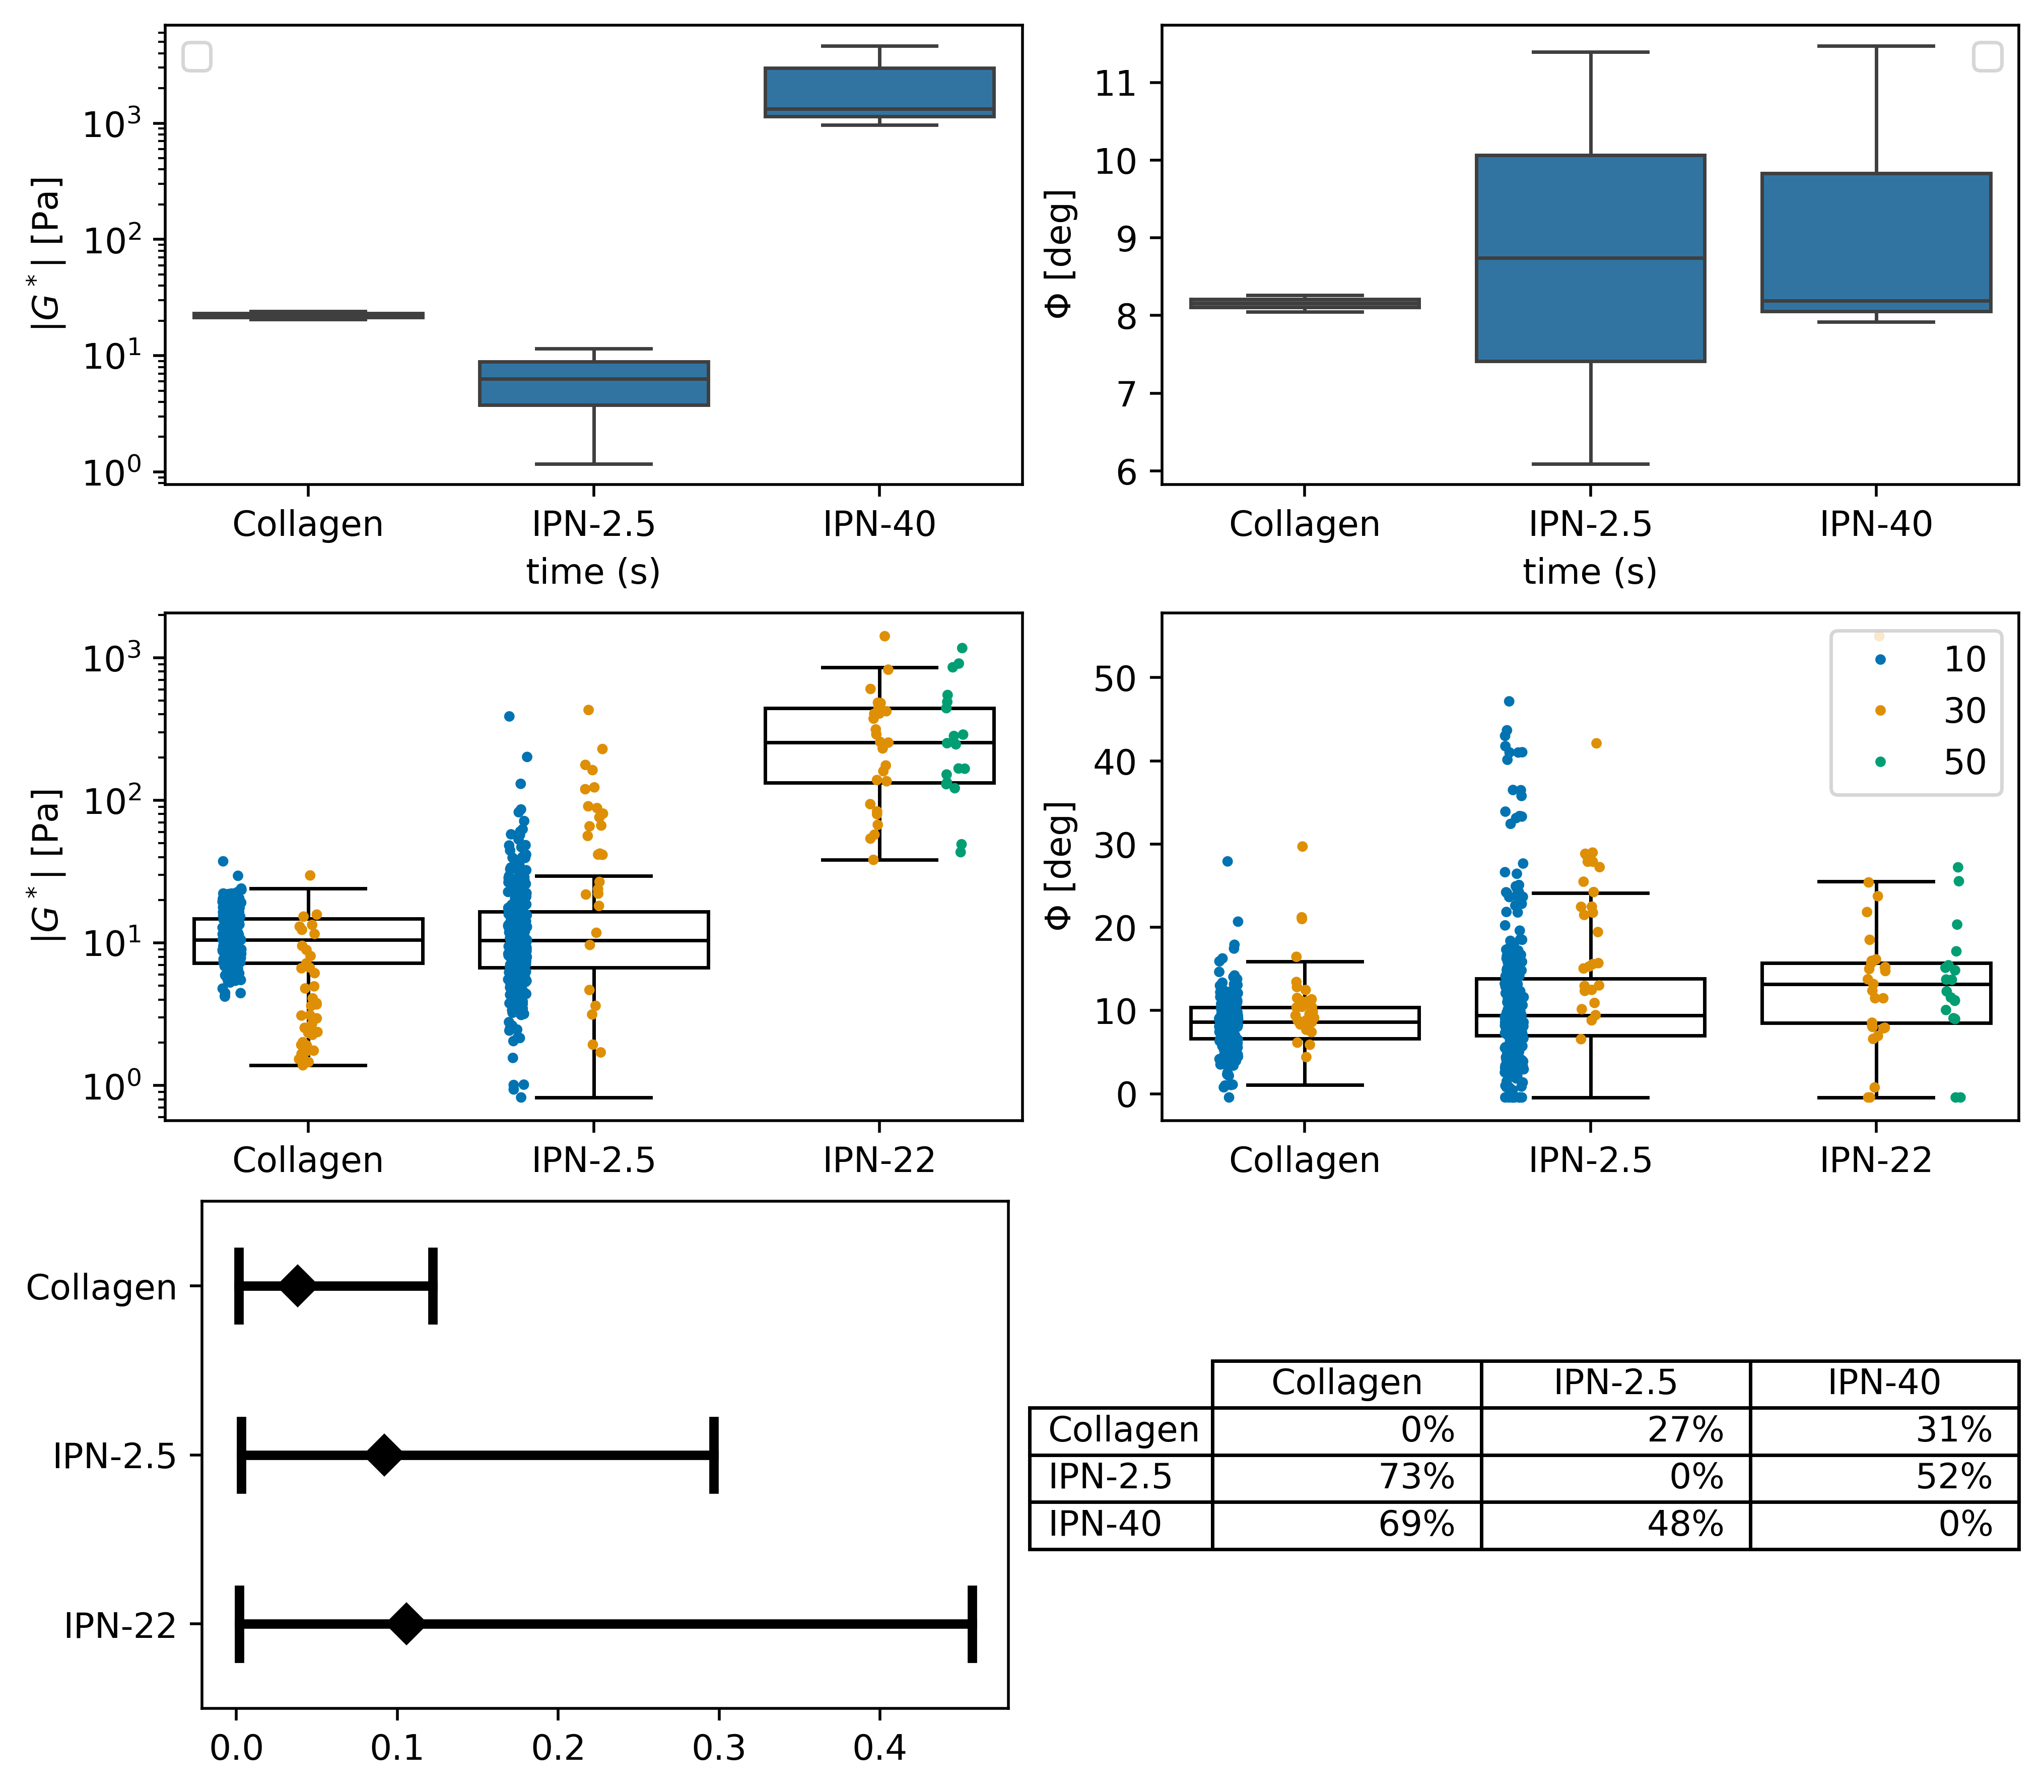

In [58]:
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}

fig = plt.figure(constrained_layout=True, figsize=(8,7),dpi = 500)
subfigs = fig.subfigures(3, 1, wspace=0.0025, hspace=0.0025, height_ratios=[1, 1, 1])

ax0 = subfigs[0].subplots(1, 2)
ax1 = subfigs[1].subplots(1, 2)
ax2 = subfigs[2].subplots(1, 2)


df_osc_sub = df_osc[df_osc["Time"] == 100.0]

sns.boxplot(x="label", y = "Complex Shear Modulus", data = df_osc_sub, ax = ax0[0], showfliers= False, **PROPS)

ax0[0].set_yscale("log")
ax0[0].set_xlabel("time (s)")
ax0[0].set_ylabel(r'${}$ [{}]'.format('|G^*|','Pa'))
ax0[0].legend("")
sns.boxplot(x="label", y = "Phase Shift Angle", data = df_osc_sub, ax = ax0[1], showfliers= False, **PROPS)
#ax[0].set_yscale("log")

ax0[1].set_xlabel("time (s)")
ax0[1].set_ylabel(r'${}$ [{}]'.format('\Phi','deg'))
ax0[1].legend(loc='upper right')



mm = data.groupby(['day', 'sample', 'holder', 'location','type','material', 'size', 'coating','track_id']).mean()

sns.boxplot(data=mm,x='type', y='G_abs',ax=ax1[0], showfliers= False, **PROPS)
sns.stripplot(data= mm, x='type',y='G_abs',ax=ax1[0], hue = "size", palette=sns.color_palette('colorblind'), legend=False, dodge = True, size =3, marker='o')

ax1[0].set_xticklabels(["Collagen", "Soft IPN", "Mid IPN", "Stiff IPN"])

sns.boxplot(data=mm,x='type', y='phi_(deg)',ax=ax1[1], showfliers = False, **PROPS)
sns.stripplot(data= mm, x='type',y='phi_(deg)',ax=ax1[1], hue = "size", palette=sns.color_palette('colorblind'), dodge=True, size =3, marker='o')

ax1[0].set_xticklabels(["Collagen", "IPN-2.5", "IPN-22", "IPN-40"])
ax1[1].set_xticklabels(["Collagen", "IPN-2.5", "IPN-22", "IPN-40"])
ax1[0].set_title('')
ax1[1].set_title('')
ax1[0].set_ylabel(r'${}$ [{}]'.format('|G^*|','Pa'))
ax1[1].set_ylabel(r'${}$ [{}]'.format('\Phi','deg'))
ax1[0].set_xlabel("")
ax1[1].set_xlabel("")
ax1[1].legend(loc='upper right')
ax1[0].set_yscale("log")

df = vals.melt()
sns.pointplot(
    data=df, x="value", y="variable",
    errorbar=("pi", 95), capsize=.4,
    color="black", linestyle="none", marker="D", ax=ax2[0]
)
ax2[0].set_ylabel("")
ax2[0].set_xlabel("")
ax2[0].set_yticklabels(["Collagen", "IPN-2.5", "IPN-22"])


columns = name_list
rows = name_list

# Plot bars and create text labels for the table
cell_text = []
for col_ in columns:
    row_text = []
    for row_ in rows:
        row_text.append(r"{}$\%$".format(int(np.round(probabilities[col_][row_]*100,0))))
    cell_text.append(row_text)

# Reverse colors and text labels to display the last value at the top.
#cell_text.reverse()

# Add a table at the bottom of the Axes
the_table = ax2[1].table(cellText=cell_text,
                      rowLabels=rows,
                      colLabels=columns,
                      loc='center')

ax2[1].axis("off")
#fig.tight_layout()

#fig.savefig("./NikonPipes/dataStore/microrheology.png",transparent=False,facecolor='white' )


(0.0, 1.0)

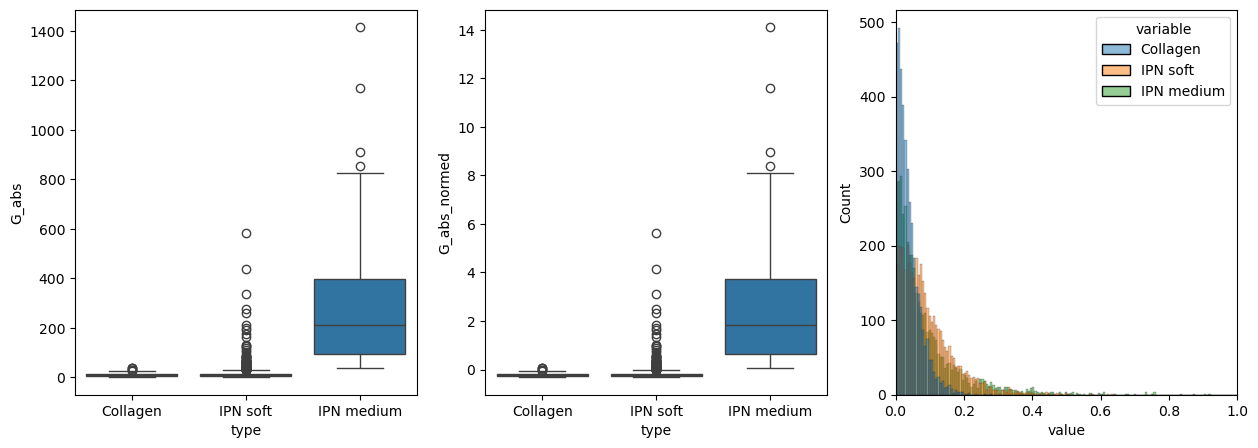

In [73]:
fig,ax = plt.subplots(1,3, figsize = (15,5))

sns.boxplot(data=data,y='G_abs',x='type',ax=ax[0])

sns.boxplot(data=data,y='G_abs_normed',x='type',ax=ax[1])

sns.histplot(data=vals.melt(),x='value',hue='variable',ax=ax[2])
ax[2].set_xlim(0,1)

plt.show()

vals = fit.draws_pd().filter(regex='^sigma_size')
vals.columns = ['10um', "30um",'50um' ] #,'IPN stiff'

fig,ax = plt.subplots()
sns.histplot(data=vals.melt(),x='value',hue='variable',ax=ax)
ax.set_xlim(0,1)
print(vals.mean(axis=0))

plt.show()

vals = fit.draws_pd().filter(regex='^alpha')
vals.columns = ['collagen', "IPN_soft",'IPN medium' ] #,'IPN stiff'

fig,ax = plt.subplots()
sns.histplot(data=vals.melt(),x='value',hue='variable',ax=ax)
ax.set_xlim(0,1)
print(vals.mean(axis=0))

plt.show()

_ = plt.hist(fit.draws_pd().filter(regex='^alpha'), alpha =0.4, label="alpha")
_ = plt.hist(fit.draws_pd().filter(regex='^beta'), alpha =0.4, label="beta")
plt.legend()
plt.show()


In [52]:
track_indices,counts = np.unique(indices['track_id'],return_counts=True)

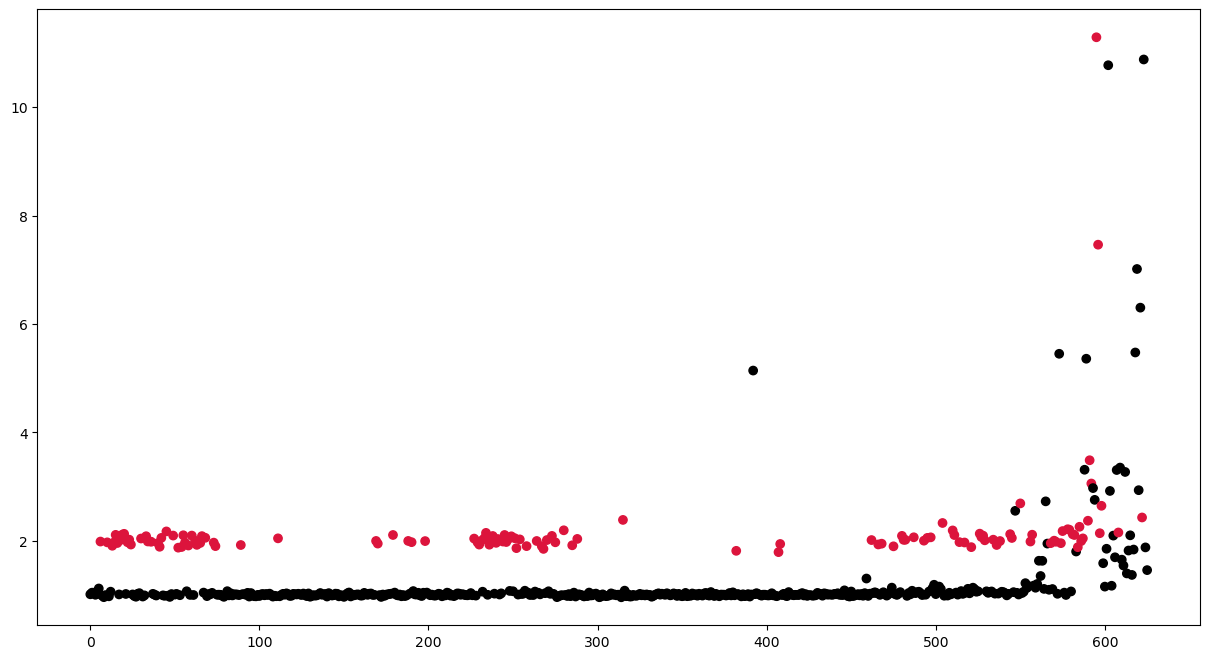

In [53]:
fig = plt.figure(figsize=(15,8))
cols = ['crimson' if i==1 else 'black' for i in counts]
plt.scatter(np.arange(sigmas.shape[1]),sigmas.mean(axis=0).values,c=cols)

In [54]:
print(data.groupby(['type','day','sample','holder','location','track_id'])[['G_abs']].std().to_string())

                                                        G_abs
type       day    sample holder location track_id            
Collagen   211029 10     10     10       0           0.162056
                                         1           5.886139
                                         2           2.722900
                                         3           3.999497
                                         4           1.578650
                                         5           0.655281
           240325 1      1      1        0                NaN
                                         2           0.618805
                                         3           2.262209
                                         4           0.146275
                                         7                NaN
                                         10          2.004349
                                         11          0.988177
                                2        0                NaN
        

In [55]:
np.median(data.groupby(['type','day','sample','holder','location','track_id'])['G_abs'].apply(lambda x: np.nanstd(x)))

0.32984265447842775

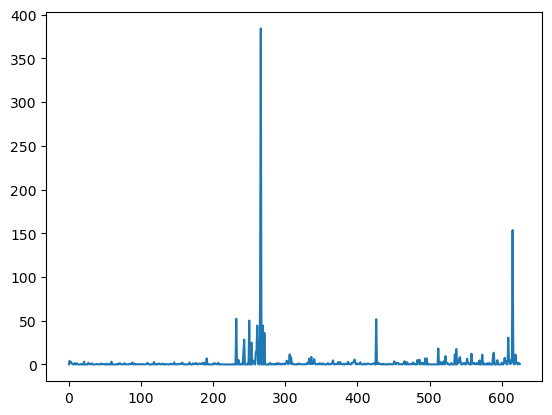

In [56]:
plt.plot(data.groupby(['type','day','sample','holder','location','track_id'])['G_abs'].apply(lambda x: np.nanstd(x)).values)

In [7]:
# hierarcical indexing
gnames = ['type','day','sample','holder','location','track_id']
g_indices = {i:[] for i in gnames}
g_orig_indices = {i:[] for i in gnames}

indices,orig_indices = _gen_indices(data,gnames,0,g_indices,g_orig_indices)

# outside hierarchy
size_indices,size_orig = index('size')
coating_indices,coating_orig = index('coating')

normalize = lambda x: data[x]\
             .div(data[x].std())

data['G_abs_normed'] = normalize('G_abs')
data['phi_normed'] = normalize('phi_(rad)')
data['radius_(m)'] = normalize('radius_(m)')

data_json = {**{f'N_{i}':len(np.unique(j)) for i,j in indices.items()},
             **{f'{i}_ids':j for i,j in indices.items()},
             'x_size':data["radius_(m)"].tolist(),
             'bead_ids':(size_indices+1).tolist(), #
             'N_bead':len(np.unique(size_indices)), #
             'y':data['G_abs_normed'].tolist(),
             'N':data.shape[0]}


with open('./dataStore/data_s.json','w') as f:
    json.dump(data_json,f)



In [8]:

model = CmdStanModel(stan_file='./model/model_o_linear_size.stan')
fit = model.sample(data='./dataStore/data_s.json', show_progress=True) #,adapt_delta=0.99,max_treedepth=15
print(fit.diagnose())

16:26:58 - cmdstanpy - INFO - compiling stan file C:\Users\lehto\git\InstruProject\microrheology\model\model_o_linear_size.stan to exe file C:\Users\lehto\git\InstruProject\microrheology\model\model_o_linear_size.exe
16:27:15 - cmdstanpy - INFO - compiled model executable: C:\Users\lehto\git\InstruProject\microrheology\model\model_o_linear_size.exe
16:27:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:33:24 - cmdstanpy - INFO - CmdStan done processing.
16:33:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[334] is inf, but must be finite! (in 'model_o_linear_size.stan', line 78, column 2 to column 90)
	Exception: normal_lpdf: Location parameter[414] is -inf, but must be finite! (in 'model_o_linear_size.stan', line 78, column 2 to column 90)
Exception: normal_lpdf: Location parameter[414] is -inf, but must be finite! (in 'model_o_linear_size.stan', line 78, column 2 to column 90)
	Exception: normal_lpdf: Location parameter[414] is -inf, but must be finite! (in 'model_o_linear_size.stan', line 78, column 2 to column 90)
Exception: normal_lpdf: Location parameter[414] is -inf, but must be finite! (in 'model_o_linear_size.stan', line 78, column 2 to column 90)
	Exception: normal_lpdf: Location parameter[480] is inf, but must be finite! (in 'model_o_linear_size.stan', line 78, column 2 to column 90)
Exception: normal_lpdf: Location

16:33:25 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 8 divergent transitions (0.8%)
	Chain 1 had 992 iterations at max treedepth (99.2%)
	Chain 2 had 3 divergent transitions (0.3%)
	Chain 2 had 997 iterations at max treedepth (99.7%)
	Chain 3 had 1000 iterations at max treedepth (100.0%)
	Chain 4 had 13 divergent transitions (1.3%)
	Chain 4 had 987 iterations at max treedepth (98.7%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


Processing csv files: C:\Users\lehto\AppData\Local\Temp\tmpd6eu55he\model_o_linear_sizesl1nz_2q\model_o_linear_size-20241231162715_1.csv, C:\Users\lehto\AppData\Local\Temp\tmpd6eu55he\model_o_linear_sizesl1nz_2q\model_o_linear_size-20241231162715_2.csv, C:\Users\lehto\AppData\Local\Temp\tmpd6eu55he\model_o_linear_sizesl1nz_2q\model_o_linear_size-20241231162715_3.csv, C:\Users\lehto\AppData\Local\Temp\tmpd6eu55he\model_o_linear_sizesl1nz_2q\model_o_linear_size-20241231162715_4.csv

Checking sampler transitions treedepth.
3976 of 4000 (99.40%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
24 of 4000 (0.60%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta cl

In [9]:
def comp(name1,name2,df):
    a = df[name1].values
    b = df[name2].values
    r = np.sum((a-b)>0)/a.shape[0]
    label = 'P( {} > {} ) = {:.4f}'.format(name1,name2,r)
    return r

def comp_all(names,df):
    probs = {}
    for i in names:
        probs[i] = {}
        for j in names:
            #if i != j:
            probs[i][j] = comp(i,j,df)
    return probs

az_sample = az.from_cmdstanpy(fit,posterior_predictive='y_hat',
                        log_likelihood='log_likelihood',
                        observed_data={'y':data_json['y']})

name_list = ['Collagen','IPN soft', 'IPN medium' ]

vals = fit.draws_pd().filter(regex='^sigma_holder')
vals.columns =  name_list #,'IPN stiff'

probabilities = comp_all(name_list, vals)

C:\Users\lehto\AppData\Local\Temp\ipykernel_6992\2063466357.py:19: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.stripplot(data= mm, x='type',y='G_abs',ax=ax1[0], hue = "size", palette=sns.color_palette('colorblind'), legend=False, dodge = True, size =3, marker='o')
C:\Users\lehto\AppData\Local\Temp\ipykernel_6992\2063466357.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1[0].set_xticklabels(["Collagen", "Soft IPN", "Mid IPN", "Stiff IPN"])
C:\Users\lehto\AppData\Local\Temp\ipykernel_6992\2063466357.py:24: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.stripplot(data= mm, x='type',y='phi_(deg)',ax=ax1[1], hue = "size", palette=sns.color_palette('colorblind'), dodge=True, size =3, marker='o')
C:\Users\lehto\AppData\Local\Temp\ipykernel_6992\2063466357.py:26: UserWarning: set_ticklabels() s

(0.0, 1.0, 0.0, 1.0)

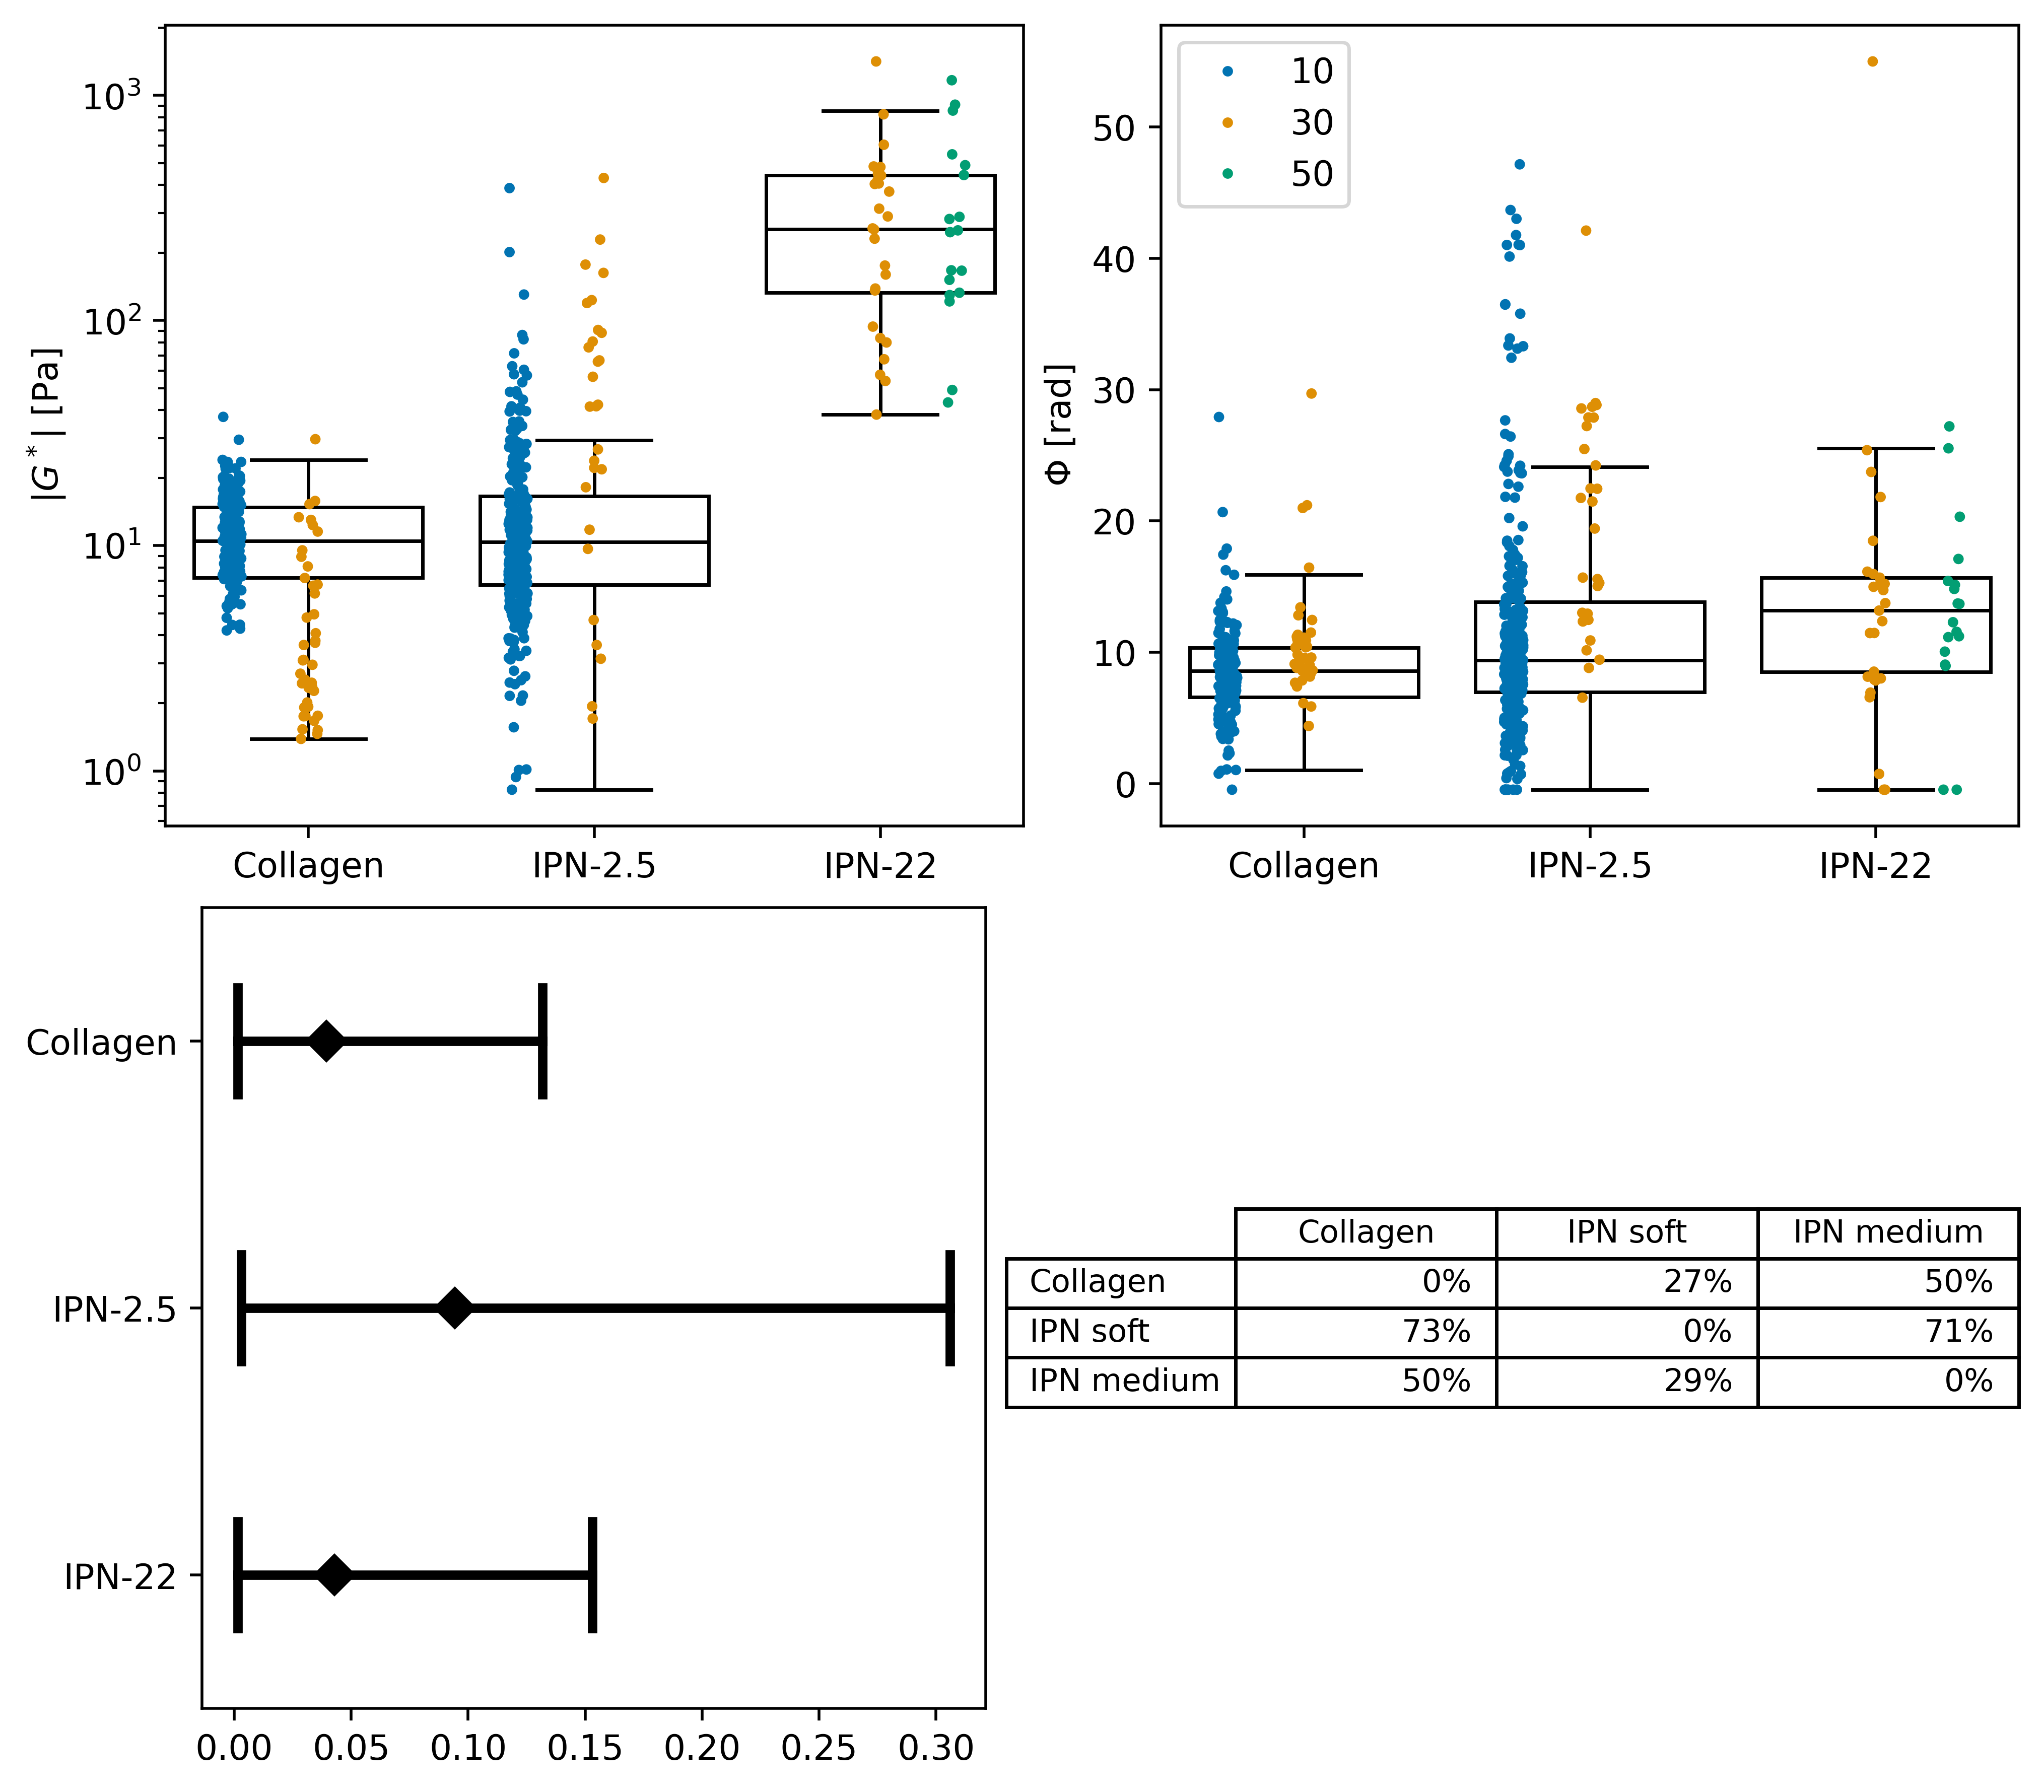

In [10]:
fig = plt.figure(constrained_layout=True, figsize=(8,7),dpi = 500)
subfigs = fig.subfigures(2, 1, wspace=0.0025, hspace=0.0025, height_ratios=[1, 1])

ax1 = subfigs[0].subplots(1, 2)
ax2 = subfigs[1].subplots(1, 2)



PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}

mm = data.groupby(['day', 'sample', 'holder', 'location','type','material', 'size', 'coating','track_id']).mean()

sns.boxplot(data=mm,x='type', y='G_abs',ax=ax1[0], showfliers= False, **PROPS)
sns.stripplot(data= mm, x='type',y='G_abs',ax=ax1[0], hue = "size", palette=sns.color_palette('colorblind'), legend=False, dodge = True, size =3, marker='o')

ax1[0].set_xticklabels(["Collagen", "Soft IPN", "Mid IPN", "Stiff IPN"])

sns.boxplot(data=mm,x='type', y='phi_(deg)',ax=ax1[1], showfliers = False, **PROPS)
sns.stripplot(data= mm, x='type',y='phi_(deg)',ax=ax1[1], hue = "size", palette=sns.color_palette('colorblind'), dodge=True, size =3, marker='o')

ax1[0].set_xticklabels(["Collagen", "IPN-2.5", "IPN-22", "IPN-40"])
ax1[1].set_xticklabels(["Collagen", "IPN-2.5", "IPN-22", "IPN-40"])
ax1[0].set_title('')
ax1[1].set_title('')
ax1[0].set_ylabel(r'${}$ [{}]'.format('|G^*|','Pa'))
ax1[1].set_ylabel(r'${}$ [{}]'.format('\Phi','rad'))
ax1[0].set_xlabel("")
ax1[1].set_xlabel("")
ax1[1].legend()
ax1[0].set_yscale("log")

df = vals.melt()
sns.pointplot(
    data=df, x="value", y="variable",
    errorbar=("pi", 95), capsize=.4,
    color="black", linestyle="none", marker="D", ax=ax2[0]
)
ax2[0].set_ylabel("")
ax2[0].set_xlabel("")
ax2[0].set_yticklabels(["Collagen", "IPN-2.5", "IPN-22"])


columns = name_list
rows = name_list

# Plot bars and create text labels for the table
cell_text = []
for col_ in columns:
    row_text = []
    for row_ in rows:
        row_text.append(r"{}$\%$".format(int(np.round(probabilities[col_][row_]*100,0))))
    cell_text.append(row_text)

# Reverse colors and text labels to display the last value at the top.
#cell_text.reverse()

# Add a table at the bottom of the Axes
the_table = ax2[1].table(cellText=cell_text,
                      rowLabels=rows,
                      colLabels=columns,
                      loc='center')

ax2[1].axis("off")
#fig.tight_layout()

#fig.savefig("./NikonPipes/dataStore/microrheology.png",transparent=False,facecolor='white' )


(0.0, 1.0)

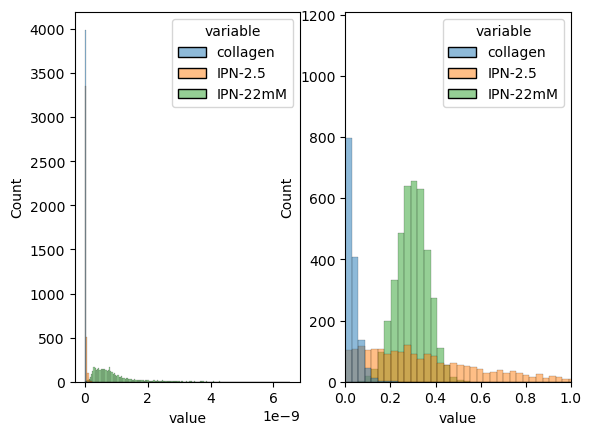

In [11]:

fig,ax = plt.subplots(1,2)

vals = fit.draws_pd().filter(regex='^sigma_bead')
vals.columns = ['collagen', "IPN-2.5",'IPN-22mM' ] #,'IPN stiff'

sns.histplot(data=vals.melt(),x='value',hue='variable',ax=ax[0])


vals = fit.draws_pd().filter(regex='^alpha')
vals.columns = ['collagen', "IPN-2.5",'IPN-22mM' ] #,'IPN stiff'

sns.histplot(data=vals.melt(),x='value',hue='variable',ax=ax[1])
ax[1].set_xlim(0,1)

<Axes: xlabel='type', ylabel='G_abs'>

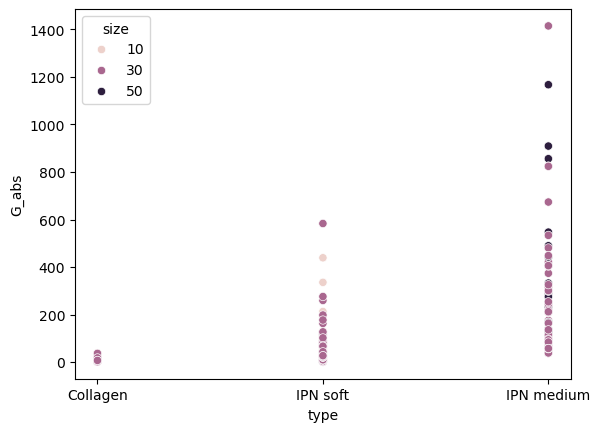

In [17]:
sns.scatterplot(data = data, x= "type", y= "G_abs", hue = "size")

In [18]:
data[data["type"] == "IPN soft"]["size"].unique()

array([10, 30])